In [1]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import sys
sys.path.append(os.path.join(os.getcwd(), "otgnn"))
sys.path.append(os.path.join(os.getcwd(), "molgen"))


%load_ext autoreload
%autoreload 2

from otgnn.models import GCN
# from molgen.dataloading.MolGraphBatchPreprocessor import MolGraph
from otgnn.graph import MolGraph
from otgnn.utils import save_model, load_model
from otgnn.graph import SYMBOLS, FORMAL_CHARGES, BOND_TYPES


from mol_opt.data_mol_opt import MolOptDataset
from mol_opt.data_mol_opt import get_loader
from mol_opt.arguments import get_args
from mol_opt.train_mol_opt import main, load_checkpoint
from mol_opt.mol_opt import MolOpt
from mol_opt.decoder_mol_opt import MolOptDecoder
from mol_opt.ot_utils import encode_target
from mol_opt.ot_utils import FGW 
from mol_opt.ot_utils import compute_barycenter

from molgen.dataloading.feat2smiles import feat2smiles
from molgen.dataloading.mol_drawer import MolDrawer
from molgen.metrics.Penalty import Penalty
from molgen.metrics.mol_metrics import MolMetrics

from rdkit.Chem import MolFromSmiles
from tensorboardX import SummaryWriter

import torch
import torch.nn.functional as F
import numpy as np
import time
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from molgen.metrics.Penalty import Penalty as PenaltyNew

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

/home/octav/gitrepos/tum-thesis


In [4]:
model_type = "pointwise"
sys.argv = ["", "-cuda", "-model_type", model_type, "-one_batch_train"]
args = get_args()
outdir_suffix = "dev1"
args.n_epochs = 100 
args.init_model = "{}-test".format(model_type)
args.init_decoder_model = "{}_decode".format(args.init_model)
args.output_dir = "mol_opt/output_{}/{}/".format(outdir_suffix, args.init_model)
args.tb_logs_dir = "mol_opt/logs_{}/{}/".format(outdir_suffix, args.init_model)
args.batch_size = 50 

In [9]:
model = args.init_model
model_iter = 99 

model_name = "model_{}_{}".format(model, model_iter)
print(args.output_dir + model_name)
model_decode_name = "model_{}_decode_{}".format(model, model_iter)

molopt, molopt_decoder, _, _, config, _ = load_checkpoint(args.output_dir + model_name)

metrics = MolMetrics(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, False)
fgw_loss = FGW(alpha = 0.5)
pen = PenaltyNew(config, model_iter)

molopt_module_list = torch.nn.ModuleList([molopt, molopt_decoder])

# molopt = MolOpt(args)
# molopt_decoder = MolOptDecoder(args)
print (molopt)
print (molopt_decoder)
print(molopt.args.model_type)
pen.log()

mol_opt/output_dev1/pointwise-test/model_pointwise-test_99
MolOpt(
  (GCN): GCN(
    (W_message_i): Linear(in_features=100, out_features=250, bias=False)
    (W_message_h): Linear(in_features=250, out_features=250, bias=False)
    (W_message_o): Linear(in_features=343, out_features=100, bias=True)
    (W_mol_h): Linear(in_features=100, out_features=100, bias=True)
    (W_mol_o): Linear(in_features=100, out_features=1, bias=True)
    (dropout_gcn): Dropout(p=0.0, inplace=False)
    (dropout_ffn): Dropout(p=0.0, inplace=False)
  )
  (opt0): Linear(in_features=100, out_features=250, bias=True)
  (opt1): Linear(in_features=250, out_features=100, bias=True)
)
MolOptDecoder(
  (fc1_SYMBOLS): Linear(in_features=100, out_features=150, bias=True)
  (fc2_SYMBOLS): Linear(in_features=150, out_features=64, bias=True)
  (fc1_CHARGES): Linear(in_features=100, out_features=150, bias=True)
  (fc2_CHARGES): Linear(in_features=150, out_features=5, bias=True)
  (fc1_BONDS): Linear(in_features=200, out_fe

In [10]:
train_data_loader = get_loader("iclr19-graph2graph/data/qed", "train_pairs", args.batch_size, True)

for i in train_data_loader:
    X = (MolGraph(i[0]))
    Y = (MolGraph(i[1]))
    break

In [11]:
x_embedding = molopt.forward(X)
yhat_logits = molopt_decoder.forward(x_embedding, X, Y)
yhat_labels = molopt_decoder.discretize_argmax(*yhat_logits)
yhat_labels = molopt_decoder.discretize(*yhat_logits, tau = pen.tau)
pred_pack = (yhat_labels, yhat_logits, Y.scope), Y 

target = Y.get_graph_outputs()
symbols_labels, charges_labels, bonds_labels = yhat_labels
symbols_logits, charges_logits, bonds_logits = yhat_logits

print (fgw_loss(*pred_pack, tau = 1).item()/args.batch_size)
pen_loss = pen(*pred_pack, model_iter)
print (pen_loss)
metrics.measure_batch(pred_pack[0], target)

0.606396141052246
(tensor(0., device='cuda:0'), tensor(1079., device='cuda:0', grad_fn=<AddBackward0>), tensor(1029., device='cuda:0', grad_fn=<AddBackward0>))


({'batch_molecular_validity': 0.0,
  'batch_correctness': 0.0,
  'batch_symbol_accuracy': 85.82020389249305,
  'batch_molecular_disconnected_validity': 0.0,
  'batch_connected_components': 4.2,
  'batch_invalid_valency_nodes': 99.81464318813717,
  'batch_nodes_0degree': 1,
  'batch_nodes_7plus_degree': 1079,
  'invalid_euler_toofew': 22.0,
  'invalid_euler_toomany': 26.0},
 {'avg_euler_error': (1.97, 50, 18.0941),
  'batch_node_degree': (79.33271547729379, 1079, 115.80681662989015)})

In [21]:
[x.item() / args.batch_size for x in pen_loss]

[0.0, 21.58, 20.58]

In [24]:
vars(args)

{'cuda': True,
 'output_dir': 'mol_opt/output_dev1/pointwise-test/',
 'tb_logs_dir': 'mol_opt/logs_dev1/pointwise-test/',
 'init_model': 'pointwise-test',
 'init_decoder_model': 'pointwise-test_decode',
 'task': 'qed',
 'model_type': 'pointwise',
 'one_batch_train': True,
 'batch_size': 50,
 'pred_hidden': 150,
 'pc_hidden': 100,
 'ffn_activation': 'LeakyReLU',
 'n_epochs': 100,
 'dim_tangent_space': 40,
 'n_layers': 5,
 'n_hidden': 250,
 'n_ffn_hidden': 100,
 'linear_out': False,
 'dropout_gcn': 0.0,
 'dropout_ffn': 0.0,
 'agg_func': 'sum',
 'batch_norm': False,
 'N_transformer': 6,
 'n_ffn_transformer': 100,
 'n_heads_transformer': 10,
 'dropout_transformer': 0.1,
 'ot_solver': 'emd',
 'sinkhorn_entropy': 0.1,
 'sinkhorn_max_it': 10000,
 'connectivity': True,
 'valency': True,
 'euler_characteristic_penalty': True,
 'annealing_rate': 0.0001,
 'connectivity_lambda': 0.025,
 'valency_lambda': 0.07,
 'euler_lambda': 0.3,
 'connectivity_hard': False,
 'valency_hard': False,
 'scale_lambd

In [13]:
bond_idx = 0
smiles = []
for mol_idx, (st, le) in enumerate(Y.scope):
    pred_symbols = symbols_labels[st:st+le]
    target_symbols = torch.argmax(target[mol_idx]['SYMBOLS'], dim=1)
    
    symbols = symbols_labels[st:st+le]
    charges = charges_labels[st:st+le]
    bonds = bonds_labels[bond_idx:bond_idx+le*le].view(le, le, -1)
    bond_idx += le * le
    smiles.append(feat2smiles(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, symbols, charges, bonds, False))
    print (smiles[-1])

C.C.C.C=C1=F(C)C2(C)CC3(=C)CC=C=C(=N)(=C1)=C3C2O.O
C.C.C=C1(C)CCN2C3C24=N325=CC4CC2(C)=C15.O
C.C.C.C=S12=C(N)=C34C56=C7=N38=CC451N(=O)C(C82)C=7(C)(N)C6
C.C.C.C.C=O.CC=C(O)CC(C)(C)(CC)CO
C.C.C.C.C=C(C)CC1=O(=C)C1.C=O(C)=C(C)C.N.N.O
C.CC1C2(C)=C3C4(C)=C56=N=CC=C317=N=N=5(C)C=76CC=C24
C.C.C=C1=F2=NO=234(=CC)C2=C1C2315(C)(C)(C=F)=CC=O1(C(C)=C=O)C45
C=CC1(FC)C2CCCO234CC(C)C=O=O=C13(=C)C4.N
C.C.CC=C1=O2=C3C4C(=O5FC15C32)=[Na](C)=C(=F)C4C.CCC
C=C123=C(=C(C)C1=CC)C2(=C(C)CCC1=CC1C)C3.N
C.C.C.C.CC12=CO34=C(C(=C(O)CCC1)CNC3)C24.O.O
C.C.C.C=CC12CC(C)(CC)C13(C)(CC)C1=N(C)=OC2C13.CC.Cl.N
C.C.C.C=C.C=O1=C2(=CC3C(C=Cl(=O)C3C)C2)C(C)(C(C)C)C(C)C1
C.C=C123=CC45=CC67(=N)C1C=218=N2=N9%10(C)CCC19(C(=C68%10)=O=4=3C2)[SH]57.O
C.C.C.C=C=N1=CC23(=C)(C)=C=CC(C)C4CC4(O)C(C2)N=1=3=C.N
C.C.C.C.C=C1=N=C2(=C(C)F2(C)CC)N2(CC2)O=1.Cl
C.C.C.C=C.CC1C(C)(C)C123CN=C1(=CC2O3C)=O=[Mo]=1
C.C=O=C12OC3456=C(=N)C17=C(=C73(C)C(C4C)C13(C)C4CC421C35)C6(C)N.N.O
C.C.C=C.C=O1234=C=C567(=CCC(C)C589(C)C=C1COC861C=72=C19(C)C3)C4.N
C.C.

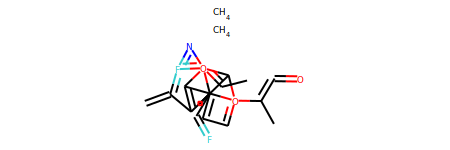

In [20]:
Chem.MolFromSmiles(smiles[6], sanitize = False)

In [136]:
mol_idx = 0 
torch.argmax(target[mol_idx]['SYMBOLS'], dim=1)

tensor([0, 0, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0])

In [137]:
(x_embedding.mean(axis = 0) / x_embedding.std(axis = 0)).abs().max()

tensor(2.0730, device='cuda:0', grad_fn=<MaxBackward1>)

In [138]:
x_embedding

tensor([[-0.0931, -0.2024, -0.4638,  ..., -0.4840,  0.5632,  0.3798],
        [-0.0430, -0.0418,  0.0322,  ..., -0.0047,  0.0708,  0.0709],
        [-0.0711, -0.1473, -0.2827,  ..., -0.2868,  0.3847,  0.2519],
        ...,
        [-0.0408,  0.0323,  0.7002,  ...,  0.3530, -0.4757, -0.1548],
        [-0.1191, -0.1112,  0.1674,  ...,  0.0200, -0.0557,  0.0492],
        [-0.1153, -0.1541, -0.1708,  ..., -0.2086,  0.2693,  0.2168]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [146]:
target_smiles = [Chem.MolToSmiles(y) for y in Y.rd_mols]
initial_smiles = [Chem.MolToSmiles(y) for y in X.rd_mols]

# uncomment for tensorboard
tb_writer = SummaryWriter(logdir = args.tb_logs_dir)
mol_drawer = MolDrawer(tb_writer, SYMBOLS, BOND_TYPES, FORMAL_CHARGES)
mol_drawer.visualize_batch(pred_pack[0], target_smiles, model_iter, initial_smiles, text="{}-manual2-".format(args.init_model))

C=c[se].cnC[SiH]=[AsH]1C[SeH]1COC1C2CC1(C)(C)C2[SH](C)C
C.C.C.C.C.C.COSC1[SiH]2[SbH][AsH]1(S)C2S.S.[AsH3]
C.COC.CPC.Cs1c=C2CC(C2)[BiH](C)(C)C1O.S[BiH2]
C.C.C.C.C.C.CNCP1(C)(C)C[Al](CN)C1.S
C.C.CP.C[Se]12C(N)Sc13(C)(C)cC2[Bi]3CC[SbH2].O.S.[TeH2]
C=[Si]12(C(OC)[Sb]3C[AsH]4(C)Cc34c)CC(C)(C)(C1)C2[SbH2].[AlH3]
C.C.C.C=cc[Te](C)(c[al]N=PC)C(C)N1(=CN)CNC1N.[SeH2].[SiH4]
'NoneType' object has no attribute 'ToBinary'
 RDKit drawing crashed while drawing PREDICTION!
smiles: {self.last_target}
prediction: {self.last_prediction}
Continuing on to the next molecule.
C.C.C.C.CCO(C)CO1CN23C4[SH]5C2N4(C)C153.N.[AsH3]
C.C.C.CCC(N)C(CNC)pcc[SbH]C.N.[AsH3].c[si](C)C
C.C.CN.CS.Ccc[SbH](C)(CC)C(N)[TeH](C)C.[AsH3]
C.CP1C2C(C)(C)C[SH]3C[bi]24(C([AsH2])[PbH])cN4CC2C[AsH]C213
'NoneType' object has no attribute 'ToBinary'
 RDKit drawing crashed while drawing PREDICTION!
smiles: {self.last_target}
prediction: {self.last_prediction}
Continuing on to the next molecule.
C.C.C.CCS12(C[AsH2])(C[AsH2])CC(C1)C2(C)(S)[A

In [483]:
feat2smiles(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, symbols, charges, bonds, False)

'o123456789%10C%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28o%29%30%31%32%33%34%35%36%37C1%11%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53o%121%11%54%55%56%57%58%59=C=2=%29%13%38%12%60%61%62%63%64%65%66%67%68%69%70%71%72o%14%392%13%29%38%73%74%75%76%77%78%79=C%15%40%12%14%39%80%81%82%83%84%85%86%87%88%89C%16%41%60%12%15%40%90%91%92%93%94%95%96%97C%14%17%42%61%16%41%60%98%99%100%101%102%103%104c2%12%39%18%43%62%14%17%42%61%105%106%107%108%109-c%13%15%16%80%19%44%632%12%18%39%43%62%110%111-c%29%40%41%81-%14%20%45%64%13%15%16%19%44%63%80-c3%301-%38%90%60%82-%17-2%21%46%65%14%20%29%40%41%45-c4%31%11-%73%91%98%83-%42-%12-%13%22%47%66123%17%21-c5%32%54-%74%92%99%84-%61-%18-%15%23%48%67-%144%11%12%13-c6%33%55-%75%93%100%85-%105-%39-%16%24%49%68-%20-15%14%15-c7%34%56-%76%94%101%86-%106-%43-%19%25%50%69-%29-2-416-c8%35%57-%77%95%102%87-%107-%62-%44%26%51%70-%40-3-%11-52-c9%36%58-%78%96%103%88-%108-%110-%63%27%52%71-%41-%17-%12-%14-1-c%10%37%59-%79%97%104%89-%109-%111-%80%28%53%72-%4

In [139]:
tau = 1
symbols_nll, charges_nll, bonds_nll = F.gumbel_softmax(tau = tau, dim=1, logits = symbols_logits), F.gumbel_softmax(tau=tau,dim=1,logits=charges_logits), F.gumbel_softmax(tau=tau,dim=1, logits = bonds_logits)

<BarContainer object of 64 artists>

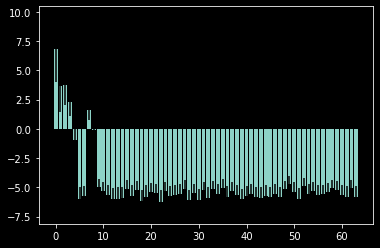

In [112]:
means = symbols_logits.mean(axis = 0).cpu().detach().numpy()
stds = symbols_logits.std(axis = 0).cpu().detach().numpy()
plt.bar(range(len(SYMBOLS)), means, yerr = stds)

<BarContainer object of 5 artists>

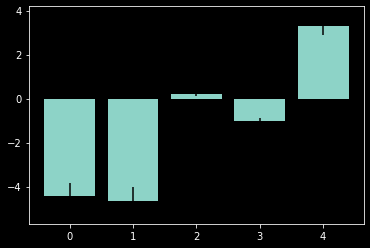

In [113]:
means = bonds_logits.mean(axis = 0).cpu().detach().numpy()
stds = bonds_logits.std(axis = 0).cpu().detach().numpy()
plt.bar(range(len(BOND_TYPES)), means, yerr = stds)

In [114]:
torch.argmax(symbols_logits/0.001, axis = 1)

tensor([2, 0, 0,  ..., 0, 0, 0], device='cuda:0')

In [115]:
torch.argmax(F.gumbel_softmax(tau = 1, dim=1, logits = symbols_logits), axis = 1)
# torch.argmax(F.softmax(symbols_logits, dim = 1), axis = 1)

tensor([2, 0, 3,  ..., 0, 0, 0], device='cuda:0')

In [116]:
symbols_logits

tensor([[ 4.7713,  7.5992,  9.1514,  ..., -6.8173, -6.0547, -7.1816],
        [ 5.4330,  4.4674,  3.4791,  ..., -5.1967, -4.5764, -5.2503],
        [ 5.4627,  4.2076,  3.3583,  ..., -5.1326, -4.5229, -5.1690],
        ...,
        [ 7.9274,  2.1972,  2.8278,  ..., -5.7688, -4.9560, -5.6737],
        [ 5.6975,  3.9418,  3.9025,  ..., -5.2325, -4.5823, -5.2952],
        [ 7.1351,  2.7051,  2.6358,  ..., -5.4611, -4.7207, -5.3825]],
       device='cuda:0', grad_fn=<CatBackward>)

In [117]:
F.gumbel_softmax(tau = 0.1, dim=1, logits = symbols_logits)

tensor([[7.9127e-27, 9.9999e-01, 5.9817e-06,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.6074e-06, 1.0000e+00, 6.5038e-13,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.2610e-07, 2.3559e-08, 2.9983e-18,  ..., 1.4013e-45, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.0000e+00, 4.4948e-15, 6.9373e-33,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 1.2925e-14, 1.0711e-13,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 8.2751e-27, 2.3159e-18,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [118]:
symbols_logits.shape

torch.Size([1079, 64])

In [119]:
symbols_labels

tensor([2, 0, 0,  ..., 0, 0, 0], device='cuda:0')

In [120]:
bonds_labels.unique(return_counts = True)

(tensor([0, 1, 2, 3, 4], device='cuda:0'),
 tensor([   14,    14,  1066,   328, 22149], device='cuda:0'))

# inspect module parameters

In [150]:
molopt_decoder.fc1_SYMBOLS

Linear(in_features=100, out_features=150, bias=True)

In [151]:
molopt_decoder.fc2_SYMBOLS(F.leaky_relu(molopt_decoder.fc1_SYMBOLS(x_embedding)))

tensor([[ 13.7881,   0.6913,   3.3530,  ..., -10.6195,  -8.9924, -11.0378],
        [ 13.5698,  -1.3311,   4.9047,  ...,  -8.9976,  -7.9215, -10.1074],
        [  5.2691,  -6.6067,   3.9132,  ..., -13.3723, -13.1498, -14.1045],
        ...,
        [  2.3633,   0.6043,   8.5959,  ..., -12.3276, -12.1154, -13.7442],
        [ 16.1051,   0.3792,   4.5413,  ...,  -8.0192,  -7.4203,  -9.7780],
        [  8.6492,   4.9261,   0.4580,  ...,  -9.5743,  -9.4313, -10.6167]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [152]:
x_embedding

tensor([[-0.1335,  0.4283,  0.3699,  ..., -0.3710,  0.7165, -0.5101],
        [-0.8927,  1.3656,  0.6950,  ..., -1.0309, -0.1640, -0.0162],
        [-0.4414, -0.3376,  2.9654,  ...,  1.0029, -0.6166,  0.1708],
        ...,
        [ 0.9006,  0.2762, -0.7614,  ...,  1.1360,  0.2881, -0.2464],
        [-1.4002,  1.4269, -0.5393,  ..., -1.6091,  0.4275, -0.0564],
        [-0.5014,  0.6323,  0.1265,  ..., -1.6008, -0.1383,  0.4430]],
       device='cuda:0', grad_fn=<AddBackward0>)

# debug connectivity

In [153]:
def get_pen(model_iter):
    model_name = "model_{}_{}".format(model, model_iter)
    model_decode_name = "model_{}_decode_{}".format(model, model_iter)
    molopt, config = load_model(args.output_dir + model_name, MolOpt, args.device)
    molopt_decoder, config_decoder = load_model(args.output_dir + model_decode_name, MolOptDecoder, args.device)
    x_embedding = molopt.forward(X)
    yhat_logits = molopt_decoder.forward(x_embedding, X, Y)
    yhat_labels = molopt_decoder.discretize_argmax(*yhat_logits)
    # yhat_labels = molopt_decoder.discretize(*yhat_logits)
    pred_pack = (yhat_labels, yhat_logits, Y.scope), Y 

    return (pen(*pred_pack, model_iter)[1].item())

In [154]:
for i in range(0, 2000):
    print (i, get_pen(1600))

FileNotFoundError: [Errno 2] No such file or directory: 'mol_opt/output_transformer10-onebatch/model_transformer10-onebatch-nonconstrained_1600'

In [ ]:
# adjM = pen_loss
# N = adjM.shape[0]
# device = adjM.device
# # We need the laplacian otherwise
# L = torch.diag(torch.matmul(adjM, torch.ones(N, device=device))) - adjM # Laplacian
# L_mod = L + torch.ones_like(L, device=device) / N
# eigenvals = torch.symeig(L_mod + 1e-06 * torch.eye(N, device=device), eigenvectors=True)[0]
# -torch.sum(torch.log(eigenvals.clamp(max = 1e-01))) + len(eigenvals) * np.log(1e-01)

In [ ]:
F.gumbel_softmax(symbols_logits, dim=1, tau=0.5)